In [1]:
import warnings
warnings.filterwarnings("ignore")
from data_analyzer import DataAnalyzer
from feature_engineer import FeatureEngineer
from model_predictor import ModelPredictor


## 1. DataAnalyzer

De las primeras cosas que debemos hacer siempre es familiarizarnos con los datos que vamos a utilizar. No podemos construir un modelo logico y valido si no tenemos una idea de que informacion le estamos suministrando.

Para esto construimos la clase `DataAnalyzer` que contiene metodos para hacer un analisis descriptivo inicial de los datos. Al inicializar la clase, el dataset es cargado y listo para ser analizado.

In [2]:
Data = DataAnalyzer("new_items_dataset.csv")

Lo primero que hacemos es estudiar de manera general los datos, para responder preguntas como: como se distribuyen? Que tan variables son? existen valores extremos o muy extraños? Esto podemos hacerlo con el metodo `summary()` de nuestra clase.

In [3]:
numeric_describe, cat_describe = Data.summary()
display(numeric_describe)
display(cat_describe)

base_price          price  initial_quantity  sold_quantity  \
count       99996.00       99992.00          99996.00       99996.00   
mean        55067.93       52528.46             35.09           2.40   
std       8632656.34     8623472.10            421.08          42.69   
min             0.84           0.84              0.00           0.00   
25%            90.00          90.00              1.00           0.00   
50%           250.00         250.00              1.00           0.00   
75%           800.00         800.00              2.00           0.00   
max    2222222222.00  2222222222.00           9999.00        8676.00   

       available_quantity  
count            99996.00  
mean                34.84  
std                420.82  
min                -58.42  
25%                  1.00  
50%                  1.00  
75%                  2.00  
max               9999.00

Variable                                      Unique_Values  \
0           seller_country              [Argentina, nan, tribunales, Almagro]   
1          seller_province  [Buenos Aires, Capital Federal, Tucumán, Entre...   
2              seller_city  [General Rodríguez, MICROCENTRO, Morón, acassu...   
3           seller_loyalty  [silver, bronze, free, gold, gold_special, gol...   
4              buying_mode  [buy_it_now, classified, auction, nan, ['dragg...   
5            shipping_mode  [custom, not_specified, me2, me1, nan, -34.603...   
6   shipping_admits_pickup                [True, False, nan, [], True, False]   
7         shipping_is_free       [False, True, nan, me2, False, True, custom]   
8                   status   [active, paused, nan, 1, closed, not_yet_active]   
9               sub_status                 [nan, suspended, expired, deleted]   
10                warranty  [nan, Sí, Oferta con confianza - Revisa nuestr...   
11                  is_new                                             [0, 1]   

    N_Unique_Values             Mode  
0                 3        Argentina  
1                26  Capital Federal  
2              3655             CABA  
3                11           bronze  
4                 4       buy_it_now  
5                 6              me2  
6                 5             True  
7                 6            False  
8                 5           active  
9                 3        suspended  
10            10264               Sí  
11                2                1

En primera instancia vemos como en las variables númericas existen valores bien particulares, que nos indican pueden ser producto de errores, como por ejemplo un precio de 2 billones o cantidades negativas. estos valores debemos tratarlos antes de seguir para garantizar que a nuestro modelo le entregamos solo información limpia y confiable

Por parte de las variables categóricas, podemos ver también que algunas de ellas tienen categorias que no hacen sentido con la variable. Por ejemplo la variable `shipping_mode` tiene casos donde es igual a `-34.603`, lo cual ciertamente no es un modo de envio. De la misma manera las variables `seller_loyalty` o `buying_mode` poseen casos similares. Debido a la prevalencia de estos casos en la base, donde cada uno es inferior al 1%, los eliminamos para no afectar analisis posteriores.

Ahora podemos revisar la completitud de los datos, analizando el porcentaje de faltantes de cada columna para en caso de ser necesario empezar a depurar la base desde el inicio. De haber variables donde su gran mayoria son valores faltantes se deben eliminar pues no tiene sentido entregar a los modelos o perder el tiempo analizando variables con tan poca informacion. Esto podemos hacerlo facilmente con el metodo `missing_values()`

In [4]:
Data.missing_values()

Numero_Nulos  Porcentaje_Nulos
sub_status                     99014              0.99
warranty                       60894              0.61
seller_city                        8              0.00
price                              8              0.00
seller_country                     7              0.00
seller_province                    7              0.00
seller_loyalty                     4              0.00
sold_quantity                      4              0.00
initial_quantity                   4              0.00
status                             4              0.00
shipping_is_free                   4              0.00
shipping_admits_pickup             4              0.00
shipping_mode                      4              0.00
buying_mode                        4              0.00
id                                 4              0.00
title                              4              0.00
seller_id                          4              0.00
pictures                           4              0.00
variations                         4              0.00
attributes                         4              0.00
tags                               4              0.00
category_id                        4              0.00
base_price                         4              0.00
date_created                       4              0.00
available_quantity                 4              0.00
is_new                             0              0.00

Hay dos variables `sub_status` y `warranty` que tienen un numero muy alto de faltantes, siendo este mayor al 60% en ambos casos, por lo cual se recomeinda simplemente no tener en cuentas dichas variables, no contienen practicamente nada de informacion e incluso imputarlas seria inutil.

Se construyo el metodo `analyze_columns_missing()` para entregar un concepto de que columnas eliminar, cuales iputar y cuales simplemente remover los faltantes, de acuerdo al porcentaje de informacion no disponible de cada una.

In [5]:
Data.analyze_columns_missing()

Las Columnas a eliminar son aquellas con un alto porcentaje de valores nulos (> 50%), lo cual incluso al imputarlas estariamos trabajando con variables que son en su mayoría sintenticas: 
- sub_status
- warranty

Las Columnas a imputar son aquellas con un moderado porcentaje de valores nulos (< 50%), que podrían verse beneficiadas de las tecnicas: 
- 

Las Columnas a eliminar valores faltantes son aquellas con un porcentaje muy bajo de valores faltantes (<1%), por lo que eliminar unicament estos valores no ocasionaría problemas futuros en el análisis: 
- id
- title
- date_created
- base_price
- price
- category_id
- tags
- attributes
- variations
- pictures
- seller_id
- seller_country
- seller_province
- seller_city
- seller_loyalty
- buying_mode
- shipping_mode
- shipping_admits_pickup
- shipping_is_free
- status
- is_new
- initial_quantity
- sold_quantity
- available_quantity


Ahora, podemos analizar los valores que pueden parecer muy extremos en las variables numericas, como habiamos visto anteriormente. Para esto, desarrollamos el metodo `check_outliers()` el cual nos permite revisar los valores extremos de nuestras vairables numericas mediante dos metodos diferentes: 
- El rango intercuartil: Considera como valores extremos todos aquellos que se encuentren por fuera del rango de $Q_1-1.5*(Q_3-Q_1)$ y $Q_3+1.5*(Q_3-Q_1)$
- El z-score: Considera como valores extremos todos aquellos con un valor "z" mayor a 3 o menor a -3. Donde el "Z-Score" se define como: $(X_i-\mu)/\sigma$

In [6]:
Data.check_outliers(method="IQR")

Variable: base_price
Limíte Superior: 1865.0
Limíte Inferior: -975.0
Numero Outliers: 14638
Porcentaje Outliers: 14.64%


Variable: price
Limíte Superior: 1865.0
Limíte Inferior: -975.0
Numero Outliers: 14635
Porcentaje Outliers: 14.64%


Variable: initial_quantity
Limíte Superior: 3.5
Limíte Inferior: -0.5
Numero Outliers: 21219
Porcentaje Outliers: 21.22%


Variable: sold_quantity
Limíte Superior: 0.0
Limíte Inferior: 0.0
Numero Outliers: 16923
Porcentaje Outliers: 16.92%


Variable: available_quantity
Limíte Superior: 3.5
Limíte Inferior: -0.5
Numero Outliers: 20415
Porcentaje Outliers: 20.41%


In [7]:
Data.check_outliers(method="zscore")

Variable: base_price
Numero Outliers: 9
Porcentaje Outliers: 0.01%

Variable: price
Numero Outliers: 5
Porcentaje Outliers: 0.01%

Variable: initial_quantity
Numero Outliers: 196
Porcentaje Outliers: 0.20%

Variable: sold_quantity
Numero Outliers: 270
Porcentaje Outliers: 0.27%

Variable: available_quantity
Numero Outliers: 195
Porcentaje Outliers: 0.19%



Los valores que se consideran como extremos difieren bastante dependiendo del metodo que utilicemos, siendo el IQR un metodo mas acido y el Z Score uno mas laxo. En este caso nos iremos por el Zsore para evitar ser tan estrictos con los valores y no eliminar informacion relevante.

Ahora con el metodo `clean_data()` llevamos a cabo la limpieza de los datos, de acuerdo a los resultados de los analisis anteriores:
- Eliminamos columnas con alto numero de faltantes
- Imputamos columnas donde tengamos informacion suficiente
- Eliminamos valores faltantes especificos donde sean de baja frecuencia
- Elimiamos valores no coincidentes de las variables categoricas
- Ajustamos valores extemos

In [8]:
Data.clean_data(remove_na=True)

id                                              title  \
0      MLA578569012                  Escritorio Secretter Espectacular   
1      MLA576883746    Stassen Espatulas Milenio Numero 3 Codigo 590-3   
2      MLA581002506  Charm Britania Plata 925 Ovalado!!! Armá La Tu...   
3      MLA574707083    El Hombre De Magallanes Virginia Carreño Novela   
4      MLA576209717  Molde Placa Boca Espejo Bota Labial Chupetin P...   
...             ...                                                ...   
99995  MLA579464055             Excelentes Zuecos  !!! Imperdibles!!!!   
99996  MLA578257287  Academia Nacional De Bellas Artes 1878 1928 Ci...   
99997  MLA581361773  Bateria 12n5-3b Yamaha Ybr 125 C.c! En Wagner ...   
99998  MLA576082728  Mini Vestido/remera De Pailets Super Cool- Imp...   
99999  MLA582542755  El Fin De Las Libertades - Benegas Lynch (h) -...   

                   date_created  base_price    price category_id  \
0      2015-09-08T21:17:57.000Z     6700.00  6700.00     MLA1902   
1      2015-08-29T12:55:03.000Z      119.00   119.00     MLA3530   
2      2015-09-23T12:41:07.000Z      450.00   450.00     MLA6440   
3      2015-08-16T13:34:01.000Z       40.00    40.00     MLA2044   
4      2015-08-25T14:42:20.000Z       30.00    30.00    MLA34294   
...                         ...         ...      ...         ...   
99995  2015-09-14T16:06:16.000Z      250.00   250.00   MLA370638   
99996  2015-09-07T13:38:31.000Z     1000.00  1000.00    MLA11456   
99997  2015-09-25T14:52:37.000Z      350.00   350.00    MLA61231   
99998  2015-08-24T19:55:02.000Z     1200.00  1200.00   MLA373722   
99999  2015-10-02T13:36:50.000Z       68.00    68.00     MLA1227   

                              tags  \
0      ['dragged_bids_and_visits']   
1      ['dragged_bids_and_visits']   
2      ['dragged_bids_and_visits']   
3      ['dragged_bids_and_visits']   
4      ['dragged_bids_and_visits']   
...                            ...   
99995                           []   
99996  ['dragged_bids_and_visits']   
99997  ['dragged_bids_and_visits']   
99998  ['dragged_bids_and_visits']   
99999  ['dragged_bids_and_visits']   

                                              attributes  \
0                                                     []   
1                                                     []   
2                                                     []   
3                                                     []   
4                                                     []   
...                                                  ...   
99995  [{'value_id': 'female', 'attribute_group_id': ...   
99996                                                 []   
99997                                                 []   
99998  [{'value_id': 'female', 'attribute_group_id': ...   
99999                                                 []   

                                              variations  \
0                                                     []   
1                                                     []   
2                                                     []   
3                                                     []   
4                                                     []   
...                                                  ...   
99995  [{'attribute_combinations': [{'value_id': '919...   
99996                                                 []   
99997                                                 []   
99998  [{'attribute_combinations': [{'value_id': '920...   
99999                                                 []   

                                                pictures  ...  status is_new  \
0      [{'size': '500x375', 'secure_url': 'https://a2...  ...  active      0   
1      [{'size': '500x375', 'secure_url': 'https://a2...  ...  active      1   
2      [{'size': '312x308', 'secure_url': 'https://a2...  ...  active      1   
3      [{'size': '375x500', 'secure_url': 'https://a2...  ...  active      0   
4      [{'si

Listo! Nuestros datos estan limpios y aptos para el modelado

## 2. FeatureEngineer

Ahora utilizamos nuestra clase `FeatureEngineer` para transformar variables de acuerdo a su tipo y seleccionar las mas adecuadas para el problema de prediccion que tenemos.

Dado el dataset con el que contamos, uno de los analisis mas utiles que podemos hacer es estudiar de que depende la cantidad de unidades vendidas de un producto, en funcion de su precio y las caracteristicas de la publicacion. Este analisis nos permitira encontrar la elasticidad precio-demanda, dandonos informacion util para tomar decisiones de pricing como campañas promocionales que involucren el producto y adicional, encontrar los determinantes que hacen que un producto sea mas o menos atractivo para los clientes.

Se propone un modelo del tipo:
$$Cantidad = f(precio, X_{publicacion}) +\epsilon$$

Otro modelo que puede ser util es analizar si un producto fue o no vendido, para (de manera complementaria al modelo anterior) analizar las caracteristicas de la publicacion que resultan relevantes para un cliente al determinar si compra o no un articulo. 
 $$Y_i=
    \begin{cases}
      1 & \text{Si el producto $i$ ha sido vendido} \\
      0 & \text{d.l.c.}
    \end{cases}
    $$
    
En ese caso, se construye una variable binaria que toma el valor de 1 si el articulo se ha vendido y 0 de lo contrario. Con esta, se procede con el modelo, transformando el problema de uno de regresion a uno de clasificacion


$$Y_i=
    \begin{cases}
      1 & \text{Si } \textit{sold\_quantity}_i > 0 \\
      0 & \text{d.l.c.}
    \end{cases}$$

In [9]:
FeatureEng = FeatureEngineer(Data)

Antes de poder modelar, debemos hacer los tratamientos necesarios que requieran cada una de las variables de acuerdo a sus tipos y el tipo de algoritmos que queramos probar:

* Para las variables **númericas:** Puede ser de utilidad (por ejemplo para modelos de regresión, svm o nn, en general modelos donde las distancias sean relevantes) escalar o estandarizar los datos, esto podemos hacerlo con las funcionalidades de:
    - `StandardScaler()` $\rightarrow$ Estandarización basica, resta la media y divide sobre la desviación para obtener variables de media 0 y varianza unitaria.
    - `MinMaxScaler()` $\rightarrow$ Busca dejar todos los valores entre 0 y 1
    - `RobustScaler()` $\rightarrow$ Igual que la estandarización básica pero en lugar de usar la media y la varianza usa la mediana y el IQR, que son estadísiticas robustas a outliers. 
    
    
* Para las variables **categóricas:** Debe realizarse algún tipo de transformación para que los modeos puedan utilizarlas:
    - `OneHotEncoder()` $\rightarrow$ La manera mas conocida de tratar con variables categóricas, creando variables binarias para cada una de las categorías, así cada una de las nuevas variables represeta la pertenencia de cada categoría. Tiene la desventaja de que, dependiendo en número de categorías, puede aumentar en gran medida la dimensionalidad de la base.
    - `LabelEncoder()` $\rightarrow$ Transforma las categorías en números de 0 a $k$ (número categorías). Tiene la ventaja de no deformar la base, pero el problema de que se pierde el ordenamiento de la variable, en caso de ser ordinal o que los modelos no pueden correctamente interpretar que cada número como una categoría.
    - `TargetEncoder()` $\rightarrow$ Codifica cada categoía de acuerdo al valor medio de la variable de respuesta, de esta manera cada label se transforma en un número que contiene información acerca de la probabilidad de ocurrencia de la clase positiva de la variable de respuesta. Es muy util, pero debe usarse con cuidado de no causar leakage. 

El tratamiento que decidamos hacerle a los datos, lo podemos realizar con el metodo `transform_features()` que toma un `Scaler` y un `Encoder` y se lo aplica a los datos disponibles, dejandolos listos para ser entregados al modelo
    

In [10]:
FeatureEng.transform_features()

price  seller_country  seller_province  seller_city  seller_loyalty  \
95956  -0.06            0.00             1.00      1530.00            0.00   
28239  -0.06            0.00             1.00      2565.00            0.00   
35530  -0.06            0.00             0.00       928.00            0.00   
33138  -0.06            0.00             1.00      2028.00            0.00   
78093  -0.06            0.00             1.00       462.00            1.00   
...      ...             ...              ...          ...             ...   
6296   -0.06            0.00             0.00      1362.00            0.00   
55150  -0.06            0.00             1.00       593.00            0.00   
77186  -0.03            0.00             1.00       198.00            0.00   
865    -0.06            0.00            14.00      1427.00            0.00   
15879   0.04            0.00             1.00       370.00            0.00   

       buying_mode  shipping_mode  shipping_admits_pickup  shipping_is_free  \
95956         1.00           2.00                    1.00              0.00   
28239         1.00           3.00                    0.00              0.00   
35530         1.00           2.00                    1.00              0.00   
33138         1.00           2.00                    1.00              0.00   
78093         1.00           3.00                    1.00              0.00   
...            ...            ...                     ...               ...   
6296          1.00           0.00                    1.00              0.00   
55150         1.00           2.00                    1.00              0.00   
77186         1.00           2.00                    1.00              1.00   
865           1.00           2.00                    1.00              0.00   
15879         1.00           3.00                    1.00              0.00   

       is_new  
95956    1.00  
28239    0.00  
35530    1.00  
33138    1.00  
78093    0.00  
...       ...  
6296     1.00  
55150    0.00  
77186    1.00  
865      1.00  
15879    1.00  

[79627 rows x 10 columns]

Antes de entrenar el modelo (y asumiendo que tengo un numero considerable de variables) puede ser útil hacer algun tipo de seleccion de variables para quedarnos unicamente con aquellas que mas información entreguen al modelo a la hora de hacer la predicción. 

Este procedimiento podemos hacerlo de manera "manual" con el análisis descriptivo que hicimos de las variables o pruebas de hipótesis o con métodos un poco mas automáticos como `SelectKBest()`, el cual puede ser ajustado para que utilice varios scores de importancia. Tambien podemos utilizar metodos iterativos para encontrar el subset mas adecuado para el problema. 

En este caso, nuestro metodo `select_features()` utiliza tanto `VarianceThreshold()` para eliminar variables de poca varianza y `SelectKBest()` para seleccionar las variables que tengan una mayor realcion con la variable de respuesta, la cantidad en nuestro caso, al finalizar nos entrega la lista de seleccionadas.

In [11]:
FeatureEng.select_features()

Las variables seleccionadas son: 
- price
- seller_province
- seller_loyalty
- buying_mode
- shipping_mode
- shipping_admits_pickup
- shipping_is_free
- is_new


## 3. ModelPredictor

Ahora que tenemos las variables que usaremos en el modelo, es hora de construirlo. Lastimosamente, no existe un único modelo o metodología que se ajuste a todas las situaciones, dependen del problema y la necesidad de negocio particular. Por esta razón, es aconsejable probar distintos modelos con diferentes enfoques y compararlos con el fin de encontrar el más adecuado.

Para esto se desarrollo la clase `ModelPredictor` para entrenar varios tipos de modelos y escoger el mejor de acuerdo a una metrica especificada. Al momento de escribir, la clase prueba 5 modelos diferentes:
* Random Forest
* Elastic Net Regression
* Light Gradient Boosting
* Ridge Regression
* Lasso Regression

Cada uno de los modelos construidos debe pasar por una calibración de hiperparámetros via validación cruzada para garantizar que se ha encontrado el mejor modelo para la situación particular y que evitar que se de overfitting en el mismo.

Hay varias maneras de hacer validación cruzada, todas muy validas:
* **Busqueda Exhaustiva:** Esto se hace mediante el método `GridSearchCV()` el cual, prueba todas las combinaciones posibles de hiperparametros, de acuedo a lo especificado, y devuelve la mejor. Tiene la desventaja de que puede llegar a demorarse mucho dependiendo de que tantas combinaciones existan o de inducir overfitting si la grilla bajo la cual se buscan los hiperparametros es muy fina.

* **Busqueda Aleatoria:** Esto se hace mediante el método `RandomizedSearchCV()` el cual, prueba un numero fijo de combinaciones de hiperparámetros, escogiendo cada combinación de manera totalmente aleatoria. Tiene la ventaja de ser mucho mas rapido que el método anterior, pero como solo prueba unas combinaciones particulares de hiperparámetros, puede que no este encontrando el verdadero óptimo.

* **Busqueda Guiada (Optimización Bayesiana):** Esto puede hacerse desde `optuna` o, aun mas sencillo, el objeto `model_optimizer()` de nuestra librería. Este método, a diferencia de los dos anteriores, se ejecuta de maneras iterativa, donde cada combinación de parámetros que se prueba viene alimentada de la información que va consatruyendo sobre la función objetivo. 

Una decisión importante que nos falta tomar es, cual sera la métrica que usaremos para calibrar y comparar los modelos? La respuesta a esta pregunta dependerá en gran medida del tipo de modelo que tengamos o del uso que queremos que tenga. Algunas de las métricas mas comunes son:

**Cuando el problema es de clasificación**

* **AUC:** El área bajo la curva ROC es una de las metricas mas recomendadas para utilizar pues es completamente agnóstica al punto de corte o *threshold* que tenga el modelo, por esto mismo es una de las pocas metricas que puede dar una estimación insesgada del desempeño del modelo en los casos donde se tienen datos desbalanceados. El maximizar el AUC a su vez nos permite (de manera secundaria) maximizar el recall o la precisión al escoger determinado *threshold*, pues el AUC nos muestra el potencial total de discriminación entre clases del modelo, todos los valores de recall y precisión a los que podemos llegar con los distintos puntos de corte.


* **Recall:** El recall mide la capacidad que tiene el modelo de identificar correctamente la clase positiva. Se mide de acuerdo a la formula:

$$Recall = P(\hat{y}=1|y=1) = \frac{TP}{TP+FN}$$

* **Precisión:** La precisión es la confiabilidad que se tiene de las predicciones del modelo, mide que porcentaje de aquellos predichos como positivos, son realmente positivos. Se mide de acuerdo a la formula:

$$Precisión = P(y=1|\hat{y}=1) = \frac{TP}{TP+FP}$$

* **F1 Score:** El f1 score nos muestra de manera combinada tanto la precisión como el recall de nuestro modelo. Se define como la media armonica entre ambos valores:

$$F1 = 2*\frac{precision*recall}{precision+recall}$$

* **Log Loss**: Es una métrica que mide la calidad de las probabilidades predichas por el clasificador en lugar de los labels y se define como el negativo de la verosimilitud de que la probabilidad predicha del modelo dado que se tienen un label positivo. La ventaja de usar esta metrica es la obtención de un modelo con probabilidades bien calibradas en el conjunto de train. Para una única observación se define como:

$$Log Loss = -\left(y*log\left(\hat{P}(y=1)\right)+(1-y)*\hat{P}(y=0)\right)$$

**Cuando el problema es de regresión**

* **MSE:** Es una métrica que de riesgo que corresponde al valor esperando del error (o perdida) cuadrática. Mide la diferencia promedio que existe entre el valor real de la variable predictora y la predicción generada por el modelo. Se calcula como:
$$MSE = \frac{1}{N}\sum_{i=1}^{n}(y_i-\hat{y}_i)^2$$

* **$R^2$:** También conocido como el coeficiente de determinación, representa la proporción de la varianza de nuestra variable dependiente que esta siendo explicada por el modelo (la combinación de las variables independientes). Es una medida de la bondad de ajuste del modelo y da una idea de que tan buenas serán las predicciones de nuevas observaciones.
 $$R^2 = \frac{\sum_{i=1}^{n}(\hat{y}_i-\bar{y})^2}{\sum_{i=1}^{n}(y_i-\bar{y})^2}$$

Dependiendo de la métrica que seleccionemos, los resultados de selección del modelo pueden cambiar radicalmente, por eso es siempre importante definir bien la mética de acuerdo al objetivo que se tenga.

Ya que en nuestro caso tenemos un problema de regresion usaremos como metrica principal el MSE con el fin de obtener modelos que sean capaces de ajustarse y predecir la gran mayoria de los datos, minimizando el error que cometemos al estimar

El metodo `model_train()`: 
1. Recibe los datos transformado y separados en sets de train y test del objeto `FeatureEngineer`
2. Entrena cada uno de los modelos definidos anteriormente. Selecciona los hyperparametros mas adecuados para cada uno haciendo uso de validacion cruzada y optimizacion bayesiana, intentando minimizar el RMSE
3. Compara el mejor modelo en cada caso, para encontrar el mas adecuado para la situacion

In [12]:
ModelPred = ModelPredictor(FeatureEng)
ModelPred.model_train()

[I 2025-09-29 12:19:49,530] A new study created in memory with name: en model
Best trial: 0. Best value: -6.86925:  10%|█         | 1/10 [00:00<00:01,  7.94it/s]

[I 2025-09-29 12:19:49,713] Trial 0 finished with value: -6.869246158422179 and parameters: {'alpha': 0.008764394837045384, 'l1_ratio': 0.00030114059629622093}. Best is trial 0 with value: -6.869246158422179.
[I 2025-09-29 12:19:49,808] Trial 1 finished with value: -6.869758411141241 and parameters: {'alpha': 0.014209449567314753, 'l1_ratio': 0.00013439535591182536}. Best is trial 0 with value: -6.869246158422179.


Best trial: 0. Best value: -6.86925:  40%|████      | 4/10 [00:00<00:00,  9.35it/s]

[I 2025-09-29 12:19:49,923] Trial 2 finished with value: -6.871162173004376 and parameters: {'alpha': 0.02773227972427767, 'l1_ratio': 0.0033613405832094326}. Best is trial 0 with value: -6.869246158422179.
[I 2025-09-29 12:19:50,024] Trial 3 finished with value: -6.887499029476714 and parameters: {'alpha': 0.18885846020483596, 'l1_ratio': 0.07248606078651434}. Best is trial 0 with value: -6.869246158422179.
[I 2025-09-29 12:19:50,114] Trial 4 finished with value: -6.893220679759532 and parameters: {'alpha': 0.26374242927961916, 'l1_ratio': 0.025500993411562842}. Best is trial 0 with value: -6.869246158422179.


Best trial: 0. Best value: -6.86925:  80%|████████  | 8/10 [00:00<00:00, 10.20it/s]

[I 2025-09-29 12:19:50,190] Trial 5 finished with value: -6.8815460749578765 and parameters: {'alpha': 0.13061755486237253, 'l1_ratio': 0.007940582037153945}. Best is trial 0 with value: -6.869246158422179.
[I 2025-09-29 12:19:50,297] Trial 6 finished with value: -6.870872889599984 and parameters: {'alpha': 0.024981213189563315, 'l1_ratio': 0.004921882147450291}. Best is trial 0 with value: -6.869246158422179.
[I 2025-09-29 12:19:50,390] Trial 7 finished with value: -6.871621701154153 and parameters: {'alpha': 0.03204110013455218, 'l1_ratio': 0.023800399289503976}. Best is trial 0 with value: -6.869246158422179.


Best trial: 8. Best value: -6.86881: 100%|██████████| 10/10 [00:00<00:00, 10.10it/s]
[I 2025-09-29 12:19:50,596] A new study created in memory with name: lgbm model


[I 2025-09-29 12:19:50,488] Trial 8 finished with value: -6.868806951203014 and parameters: {'alpha': 0.0017967043036930777, 'l1_ratio': 0.0001933728755041743}. Best is trial 8 with value: -6.868806951203014.
[I 2025-09-29 12:19:50,571] Trial 9 finished with value: -6.877388285990264 and parameters: {'alpha': 0.0884617219589577, 'l1_ratio': 0.00019419626421734713}. Best is trial 8 with value: -6.868806951203014.

Modelo: Elastic Net Regression
Metrica Train: 6.87
Metrica Test: 7.06



Best trial: 0. Best value: -7.08018:  10%|█         | 1/10 [00:08<01:17,  8.66s/it]

[I 2025-09-29 12:19:59,259] Trial 0 finished with value: -7.080183982169667 and parameters: {'max_depth': 44, 'learning_rate': 6.185113254126567e-05, 'l2_regularization': 0.9712582552098173}. Best is trial 0 with value: -7.080183982169667.


Best trial: 1. Best value: -6.67836:  20%|██        | 2/10 [00:16<01:06,  8.26s/it]

[I 2025-09-29 12:20:07,248] Trial 1 finished with value: -6.678361827200412 and parameters: {'max_depth': 44, 'learning_rate': 0.004088240140167125, 'l2_regularization': 0.6905869939345696}. Best is trial 1 with value: -6.678361827200412.


Best trial: 1. Best value: -6.67836:  30%|███       | 3/10 [00:24<00:56,  8.09s/it]

[I 2025-09-29 12:20:15,131] Trial 2 finished with value: -6.944392297102025 and parameters: {'max_depth': 42, 'learning_rate': 0.001116757491330501, 'l2_regularization': 8.385626200146419e-05}. Best is trial 1 with value: -6.678361827200412.


Best trial: 1. Best value: -6.67836:  40%|████      | 4/10 [00:25<00:32,  5.47s/it]

[I 2025-09-29 12:20:16,573] Trial 3 finished with value: -6.943763782613355 and parameters: {'max_depth': 26, 'learning_rate': 1.8162836882074764, 'l2_regularization': 0.00014799749333852595}. Best is trial 1 with value: -6.678361827200412.


Best trial: 4. Best value: -6.37903:  50%|█████     | 5/10 [00:27<00:20,  4.19s/it]

[I 2025-09-29 12:20:18,489] Trial 4 finished with value: -6.379026274441891 and parameters: {'max_depth': 19, 'learning_rate': 0.17247941080823292, 'l2_regularization': 0.0003739465453907732}. Best is trial 4 with value: -6.379026274441891.


Best trial: 4. Best value: -6.37903:  60%|██████    | 6/10 [00:28<00:12,  3.14s/it]

[I 2025-09-29 12:20:19,588] Trial 5 finished with value: -6.407879902219804 and parameters: {'max_depth': 50, 'learning_rate': 0.4778176691495456, 'l2_regularization': 0.0026509991777060216}. Best is trial 4 with value: -6.379026274441891.


Best trial: 4. Best value: -6.37903:  70%|███████   | 7/10 [00:39<00:16,  5.44s/it]

[I 2025-09-29 12:20:29,771] Trial 6 finished with value: -7.072958228752109 and parameters: {'max_depth': 13, 'learning_rate': 0.00011093627307083824, 'l2_regularization': 0.004013181830002961}. Best is trial 4 with value: -6.379026274441891.


Best trial: 4. Best value: -6.37903:  80%|████████  | 8/10 [00:48<00:13,  6.74s/it]

[I 2025-09-29 12:20:39,296] Trial 7 finished with value: -7.088657979632901 and parameters: {'max_depth': 20, 'learning_rate': 2.405274928188776e-06, 'l2_regularization': 0.6680113541241655}. Best is trial 4 with value: -6.379026274441891.


Best trial: 4. Best value: -6.37903:  90%|█████████ | 9/10 [00:49<00:04,  4.92s/it]

[I 2025-09-29 12:20:40,204] Trial 8 finished with value: -217.85492322970714 and parameters: {'max_depth': 37, 'learning_rate': 2.5189633612538707, 'l2_regularization': 8.3927786197046e-05}. Best is trial 4 with value: -6.379026274441891.


Best trial: 9. Best value: -6.35703: 100%|██████████| 10/10 [00:53<00:00,  5.32s/it]


[I 2025-09-29 12:20:43,757] Trial 9 finished with value: -6.357031241697168 and parameters: {'max_depth': 47, 'learning_rate': 0.07171341450950243, 'l2_regularization': 4.232818527787348}. Best is trial 9 with value: -6.357031241697168.

Modelo: LGBM
Metrica Train: 6.36


[I 2025-09-29 12:20:44,498] A new study created in memory with name: ridge model


Metrica Test: 6.51



Best trial: 1. Best value: -6.86879:  20%|██        | 2/10 [00:00<00:00, 13.82it/s]

[I 2025-09-29 12:20:44,581] Trial 0 finished with value: -6.868788597009784 and parameters: {'alpha': 0.0028896478406786824}. Best is trial 0 with value: -6.868788597009784.
[I 2025-09-29 12:20:44,639] Trial 1 finished with value: -6.86878857685957 and parameters: {'alpha': 0.15878898175095765}. Best is trial 1 with value: -6.86878857685957.


Best trial: 2. Best value: -6.86879:  20%|██        | 2/10 [00:00<00:00, 13.82it/s]

[I 2025-09-29 12:20:44,719] Trial 2 finished with value: -6.868787997822457 and parameters: {'alpha': 5.221165187736993}. Best is trial 2 with value: -6.868787997822457.


Best trial: 2. Best value: -6.86879:  40%|████      | 4/10 [00:00<00:00, 12.90it/s]

[I 2025-09-29 12:20:44,800] Trial 3 finished with value: -6.868788596890013 and parameters: {'alpha': 0.0038131275289462335}. Best is trial 2 with value: -6.868787997822457.
[I 2025-09-29 12:20:44,867] Trial 4 finished with value: -6.868788044042037 and parameters: {'alpha': 4.765007364074894}. Best is trial 2 with value: -6.868787997822457.


Best trial: 2. Best value: -6.86879:  60%|██████    | 6/10 [00:00<00:00, 14.03it/s]

[I 2025-09-29 12:20:44,930] Trial 5 finished with value: -6.868788597071702 and parameters: {'alpha': 0.0024122542320289806}. Best is trial 2 with value: -6.868787997822457.
[I 2025-09-29 12:20:44,982] Trial 6 finished with value: -6.868788591255291 and parameters: {'alpha': 0.047301532549949135}. Best is trial 2 with value: -6.868787997822457.


Best trial: 2. Best value: -6.86879:  80%|████████  | 8/10 [00:00<00:00, 15.69it/s]

[I 2025-09-29 12:20:45,034] Trial 7 finished with value: -6.868788498557711 and parameters: {'alpha': 0.7751463819320582}. Best is trial 2 with value: -6.868787997822457.
[I 2025-09-29 12:20:45,103] Trial 8 finished with value: -6.868788577490392 and parameters: {'alpha': 0.1538920069740913}. Best is trial 2 with value: -6.868787997822457.


Best trial: 2. Best value: -6.86879: 100%|██████████| 10/10 [00:00<00:00, 14.93it/s]
[I 2025-09-29 12:20:45,181] A new study created in memory with name: lasso model


[I 2025-09-29 12:20:45,160] Trial 9 finished with value: -6.868788593827918 and parameters: {'alpha': 0.02743578899760518}. Best is trial 2 with value: -6.868787997822457.

Modelo: Ridge Regression
Metrica Train: 6.87
Metrica Test: 7.06



Best trial: 1. Best value: -6.86879:  20%|██        | 2/10 [00:00<00:02,  3.87it/s]

[I 2025-09-29 12:20:45,580] Trial 0 finished with value: -6.990759988625004 and parameters: {'alpha': 1.414710480496736}. Best is trial 0 with value: -6.990759988625004.
[I 2025-09-29 12:20:45,738] Trial 1 finished with value: -6.868789644802881 and parameters: {'alpha': 0.00046117916633607684}. Best is trial 1 with value: -6.868789644802881.


Best trial: 1. Best value: -6.86879:  30%|███       | 3/10 [00:00<00:01,  5.18it/s]

[I 2025-09-29 12:20:45,852] Trial 2 finished with value: -6.874390724041677 and parameters: {'alpha': 0.0391985721437137}. Best is trial 1 with value: -6.868789644802881.
[I 2025-09-29 12:20:45,956] Trial 3 finished with value: -6.868791192513432 and parameters: {'alpha': 0.0007152713656417957}. Best is trial 1 with value: -6.868789644802881.


Best trial: 1. Best value: -6.86879:  60%|██████    | 6/10 [00:01<00:00,  6.29it/s]

[I 2025-09-29 12:20:46,073] Trial 4 finished with value: -6.869126853790857 and parameters: {'alpha': 0.008091236786907999}. Best is trial 1 with value: -6.868789644802881.
[I 2025-09-29 12:20:46,254] Trial 5 finished with value: -6.8758848296031045 and parameters: {'alpha': 0.04516962712579425}. Best is trial 1 with value: -6.868789644802881.


Best trial: 1. Best value: -6.86879:  80%|████████  | 8/10 [00:01<00:00,  7.78it/s]

[I 2025-09-29 12:20:46,342] Trial 6 finished with value: -6.869004228695235 and parameters: {'alpha': 0.006462450309267965}. Best is trial 1 with value: -6.868789644802881.
[I 2025-09-29 12:20:46,449] Trial 7 finished with value: -6.868894911057948 and parameters: {'alpha': 0.004541024434015591}. Best is trial 1 with value: -6.868789644802881.


Best trial: 1. Best value: -6.86879: 100%|██████████| 10/10 [00:01<00:00,  6.53it/s]

[I 2025-09-29 12:20:46,582] Trial 8 finished with value: -6.887304486242641 and parameters: {'alpha': 0.13139458673367924}. Best is trial 1 with value: -6.868789644802881.
[I 2025-09-29 12:20:46,702] Trial 9 finished with value: -6.868791396727589 and parameters: {'alpha': 0.000742725500324073}. Best is trial 1 with value: -6.868789644802881.

Modelo: Lasso Regression
Metrica Train: 6.87
Metrica Test: 7.06

Mejor Modelo: LGBM


Para este caso, podemos ver que el mejor modelo resulto ser el LGBM

De igual manera se construyo el metodo `compare_models()` para tener una vision mas amplia del desempeño de cada modelo incorporando métricas como el error absoluto y el r cuadrado

In [13]:
ModelPred.compare_models()

en  lgbm  ridge  lasso
MAE  2.14  1.70   2.14   2.14
MSE  7.06  6.51   7.06   7.06
R2   0.06  0.20   0.06   0.06

Por último, el método `model_predict` permite generar predicciones sobre un conjunto de datos, usando el mejor modelo seleccionado y las variables mas importantes

In [14]:
ModelPred.model_predict()

array([19.61057628,  0.62693737,  0.97624536, ...,  0.10855472,
        0.10855472,  0.10855472])

## 4. Análisis de Resultados

In [15]:
ModelPred.compare_models()

en  lgbm  ridge  lasso
MAE  2.14  1.70   2.14   2.14
MSE  7.06  6.51   7.06   7.06
R2   0.06  0.20   0.06   0.06

De los modelos analizados, el light gradient boosting es aquel que presenta un mayor desempeño en todas las métricas analizadas, teniendo los valores mas bajos en el error absoluto y error cuadrático y a su vez, el valor mas alto en el R cuadrado. El LGBM se presenta como un modelo con un error muy bajo de estimación y un ajuste considerable, aunque un R cuadrado de 0.2 sigue siendo un valor bajo.

Aunque todos los modelos presentan errores relativamente bajos de estimacion (al rededor de 2), sus ajustes (medidos como el R cuadrado) son bastante bajos. Esto puede deberse al hecho de que la variable que se intenta predecir es la cantidad vendida, la cual es una variable discreta y todos los modelos utilizados asumen que la respuesta es continua. 

De la misma manera, la variable de interés esta muy concentrada en 0 (aproximadamente un 80% de todas las observaciones no se han vendido) por lo que resulta bastante complicado para un modelo predecir una variable que en su mayoria es 0, ya que no parecen existir determinante unicos en productos no vendidos. Por los resultados se puede ver que no hay un perfil unico y diferencial en los artículos que no se han vendido en comparación con aquellos que si, lo que se traduce en dificultad para el modelo en hacer la separación.

Se probaron modelos de respuesta discreta como una regresión de Poisson, que pueden ser mas adecuados para el tipo de variable que se esta trabajando, pero estos resultaron tambien en un ajuste bajo, enfatizando la dificultad para separar o identificar los productos que no se han vendido y aquellos que si. Con el fin de dejar las clases construidas mas generales, de manera que puedan usarse para varios problemas, estos modelo espeificos se removieron

Como se había mencionado anteriormente, otra aproximación al problema puede ser simplemente predecir si un producto sera o no vendido de acuerdo a las carácteristicas de su publicación. Por los resultados obtenidos, es muy probable que de igual manera los modelos de clasificación que se desarrollen tengan problemas para identificar correctamente el perfil de ventas y no ventas, pues considerando las variables que se estan utilizando, ambos tipos de publicaciones parecen ser muy parecidos. 

Se recomienda hacer un trabajo mas exhaustivo de recolección de información e incluso de procesamiento de variables. El dataset original contiene por ejemplo, las fotos del producto publicado, se puede desarrollar un modelo que integre información de las fotos como número o calidad, incluso un modelo que las analice e intente determinar si el producto se vendera o no basado en ellas, un modelo basado en redes neuronales que transforme la información no estructurada de las imagenes en vectores que puedan ser usados por modelos como los entrenados aquí.

## 5. Insights

La interpretabilidad de nuestras soluciones nos ayuda a cerrar la brecha entre los diferentes equipos, sean técnicos o no. Lo que nos permite trasladar las ecuaciones del modelo a términos de negocio interpretables por cualquier tipo de audiencia

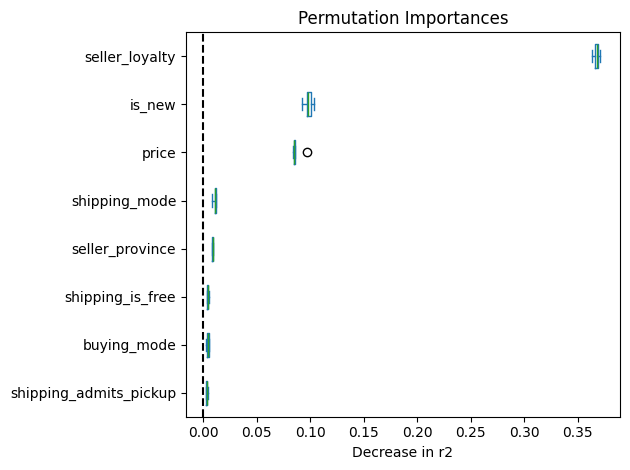

In [16]:
ModelPred.feature_importances()

La gráfica muestra la *permutation importance* mide cuánto disminuye el desempeño del modelo  cuando se altera aleatoriamente una variable. Cuanto mayor sea la caída en desempeño, más importante es esa variable para la predicción.


- `seller_loyalty` es con gran diferencia la variable más relevante.
- `is_new`(si el producto es nuevo o usado) y `price` tienen una importancia intermedia significativa.
- Variables relacionadas con envío, provincia del vendedor o modalidad de compra tienen impacto casi nulo.

#### Que nos dice la gráfica?

1. Lealtad del vendedor (seller_loyalty) como factor clave:
    - La reputación/lealtad del vendedor es lo que más predice las ventas. Esto implica que, los compradores confían más y compran más a vendedores con historial positivo.
	- Desde negocio se puede invertir en programas que fortalezcan la reputación de los vendedores (servicio al cliente, cumplimiento de envíos, reseñas positivas). También puede ser usado como criterio para promociones internas como destacar más a vendedores leales en resultados de búsqueda.

2. Estado del producto y precio como segundo nivel de importancia
    - `is_new`: los clientes claramente diferencian si el producto es nuevo o usado. Esto puede segmentar fuertemente la demanda.
    - `price`: sigue siendo un driver central, pero no es el más fuerte. Un buen precio importa, pero solo dentro del contexto de la confianza generada por el vendedor.
    - Desde negocio se pueden diseñar estrategias diferenciadas de pricing y visibilidad para productos nuevos vs usados.

3. Variables de envío, modalidad de compra y localización poco relevantes
	- `shipping_mode`, `seller_province`, `shipping_is_free` casi no afectan la predicción de ventas. Esto puede significar dos cosas:
	    1.	Los compradores priorizan confianza y reputación más que condiciones de envío.
	    2.	Las políticas de envío son más homogéneas dentro de la plataforma y no diferencian tanto a los vendedores.
	- Desde negocio se recomienda enfocarse menos en destacar si hay pickup o envío gratis, y más en reputación y precio.


La confianza en el vendedor es el factor dominante en MercadoLibre para explicar la cantidad vendida de una publicación, por encima incluso del precio o las condiciones de envío. Esto sugiere que cualquier estrategia de crecimiento de ventas debería enfocarse en:
1. Reforzar la reputación y programas de lealtad de vendedores.
2.	Diferenciar mejor productos nuevos vs usados.
3.	Optimizar pricing dinámico, pero siempre acompañado de la confianza que el vendedor genera.

#### Análisis a realizar

Como se mencionó anteriormente puede tratarse el problema como uno de regresion (como se hizo en este docuemnto) o uno de clasificacion. El modelo de regresion nos ayuda a estimar metricas como la elasticidad de un producto y encontrar cuantitativamente cual es la relacion entre el precio y la cantidad demandada. Mientras que un modelo de claisicación resulta util en cuantificar la probabilidad de que un producto se venda o no, lo que puede ser util para llevar un constante monitoreo e intentar implemtnar acciones para maximizar la visibilidad y ventas de los productos con caracteristicas mas deseables. 

En cualquiera de los casos, los pasos a seguir no cambiarían mucho de los que se propusieron aqui
1. Se deben hacer un analisis inicial de los datos, buscando y tratando con los valores faltas y extremos
2. Crear y procesar las variables que puedan resultar utiles para el problema
3. Probar varios modelos (de regresion o clasificación según sea el caso), escogiendo detalladamente la metrica correspondiente. 
4. Hacer validación cruzada y optimización de hyperparametros.
5. Comparar los distintos modelo y encontrar el mejor para el caso correspondiente.
6. Analizar los resultados y extraer insights de negocio.


## 6. Monitoreo

Se propone un monitoreo basado en 3 puntos: salud del modelo, estabilidad de las variables críticas de negocio e impacto real en ventas, con un esquema de alertas y retraining periódico.

1. **Monitoreo de desempeño del modelo - Métricas técnicas clave**:
- R² y RMSE en un set de validación temporal (últimas semanas).
- MAE segmentado por rangos de ventas (productos de alta vs baja rotación).
- Drift en la distribución de variables importantes: seller_loyalty, price, is_new, para verificar que no se estan presentando cambios bruscos que afectarian la calidad del modelo.


2. **Monitoreo de variables críticas de negocio**:

Dado que vimos que la lealtad del vendedor y el estado del producto son drivers centrales:
- Seguimiento mensual del promedio de reputación de vendedores en la plataforma: Alertas si la proporción de vendedores con baja reputación crece.
- Sensibilidad al precio: Monitorear elasticidad estimada del precio a lo largo del tiempo. Ver si el impacto del precio en las ventas se mantiene estable o cambia (ej. en periodos de inflación).

3. **Monitoreo de impacto en negocio**:

Más allá del modelo, conviene medir cómo su uso afecta la operación:
- Precision de las recomendaciones: ¿Qué tan bien predice el top de publicaciones con más ventas reales?
- Adopción en negocio: ¿Los equipos de pricing/marketing están usando las predicciones?
- Impacto financiero: Incremento de ventas en publicaciones priorizadas gracias al modelo.

4. **Estrategia operativa de monitoreo:**

Dashboards en tiempo real (por ejemplo en PowerBI, Looker, o una app en Streamlit) con las métricas mencionadas anteriormente:
- Performance del modelo.
- Drift de variables clave.
- KPIs de negocio relacionados (ventas totales, % vendedores top, etc).

Un dashboard de monitoreo continuo nos permite crear alertas automaticas en caso de que se detecte drift o el error del modelo pase cierto threshold.


## 7. Pipeline

1. Dataset en BigQuery: El dataset de entrenamiento debe ser reproducible en el tiempo. BigQuery es ideal porque permite almacenar snapshots de datos a nivel de tabla particionada, con alta escalabilidad y bajo costo de consulta.
	- Guardar el dataset final en una tabla particionada por fecha de corte y con clustering por variables de uso frecuente (category_id, seller_id).
    - Cada corrida de entrenamiento guarda un snapshot , lo que asegura reproducibilidad. Asi si en 6 meses queremos reentrenar el modelo, podemos recuperar exactamente los datos que se usaron en la versión original.

2. Modelo en MLflow: Un modelo debe tener asociados sus parámetros, métricas, firma de entrada/salida, y artefactos adicionales (feature importances, requirements). MLflow estandariza esto.
	- Cada corrida de entrenamiento genera un run en MLflow que registra:
        - Parámetros del modelo (n_estimators, max_depth, etc).
        - Métricas de desempeño (R², MAE, etc).
        - Artefactos: dataset de features, gráficos, requirements.txt.

3. Trazabilidad de punta a punta
	- El run_id de MLflow y la partición de BigQuery se enlazan en una tabla de metadatos.
	- Permite auditoría y comparación entre versiones.

4. Operativa y monitoreo: El pipeline puede orquestarse en Airflow/Composer con 3 pasos:
	1.	Extracción y construcción del dataset en BigQuery.
	2.	Entrenamiento y registro en MLflow.
	3.	Creación de dataset para el dashboard de monitoreo.
